# U-Net
In this notebook, we build a *very* basic U-Net.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [2]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.pool1 = nn.MaxPool2d(kernel_size=2)


    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.pool1(x1)
        return x1, x2
    

class UpBlock(nn.Module):
    def __init__(self, in_channels, residual_channels, out_channels):
        super().__init__()

        self.upconv1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(in_channels=in_channels + residual_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)


    def forward(self, x1, residual):
        x3 = self.upconv1(x1)
        x3 = torch.cat([x3, residual], dim=1)
        x4 = F.relu(self.bn1(self.conv1(x3)))
        return x4
            

class UNetSmol(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super().__init__()

        # Encoder
        self.down1 = DownBlock(in_channels=input_channels, out_channels=4)
        self.down2 = DownBlock(in_channels=4, out_channels=8)

        # Bottleneck
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=16)

        # Decoder
        self.up1 = UpBlock(in_channels=16, residual_channels=8, out_channels=8)
        self.up2 = UpBlock(in_channels=8, residual_channels=4, out_channels=4)
        self.conv6 = nn.Conv2d(4, output_channels, kernel_size=1)


    def forward(self, x, labels=None):
        x1, x2 = self.down1(x)
        x3, x4 = self.down2(x2)

        x5 = F.relu(self.bn3(self.conv3(x4)))

        x6 = self.up1(x5, x3)
        x7 = self.up2(x6, x1)

        x8 = self.conv6(x7)
        return x8

In [2]:
class MNISTDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        target = image.clone()
        # onehot labels
        labels = np.zeros(10)
        labels[label] = 1
        
        return image, target, torch.tensor(labels, dtype=torch.float32)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

train_noisy_dataset = MNISTDataset(train_dataset)
test_noisy_dataset = MNISTDataset(test_dataset)

train_loader = DataLoader(train_noisy_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_noisy_dataset, batch_size=32, shuffle=False)

In [5]:
model = UNetSmol()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
num_epochs = 5

from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for noisy_imgs, clean_imgs, _ in tqdm(train_loader):
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)


        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy_imgs, clean_imgs, _ in test_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            val_loss += loss.item()
    
    print(f'Validation Loss: {val_loss/len(test_loader):.4f}')


  0%|          | 0/1875 [00:00<?, ?it/s]


RuntimeError: running_mean should contain 16 elements not 32

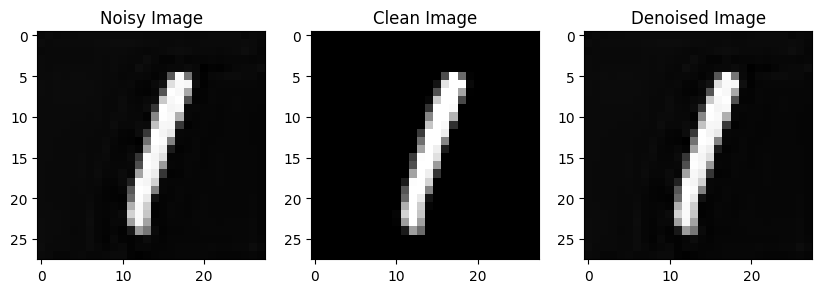

In [99]:
image, target, label = next(iter(test_loader))
out = model(image).detach().numpy()

import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

idx = 5
ax1.imshow(out[idx].squeeze(), cmap='gray')
ax1.set_title('Noisy Image')
ax2.imshow(image[idx].squeeze(), cmap='gray')
ax2.set_title('Clean Image')
ax3.imshow(out[idx].squeeze(), cmap='gray')
ax3.set_title('Denoised Image')
plt.show()

In [4]:
def add_noise(imgs: torch.Tensor):
    # randomly sample a noise factor from 0 and 0.5
    noise_factor = np.random.uniform(0, 1.0)
    pure_noise = torch.normal(mean=0.0, std=1.0, size=imgs.shape)
    noisy_imgs = (1 - noise_factor) * imgs + noise_factor * pure_noise
    # noisy_imgs = np.clip(noisy_imgs, 0., 1.)
    return noisy_imgs


In [8]:
model = UNetSmol()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
num_epochs = 5

from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for image, target, _ in tqdm(train_loader):
        noisy_imgs = add_noise(image)
        noisy_imgs, target = noisy_imgs.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for image, target, _ in test_loader:
            noisy_imgs = add_noise(image)
            noisy_imgs, target = noisy_imgs.to(device), target.to(device)
            outputs = model(noisy_imgs)
            loss = criterion(outputs, target)
            val_loss += loss.item()
    
    print(f'Validation Loss: {val_loss/len(test_loader):.4f}')


  0%|          | 0/1875 [00:00<?, ?it/s]


RuntimeError: running_mean should contain 16 elements not 32

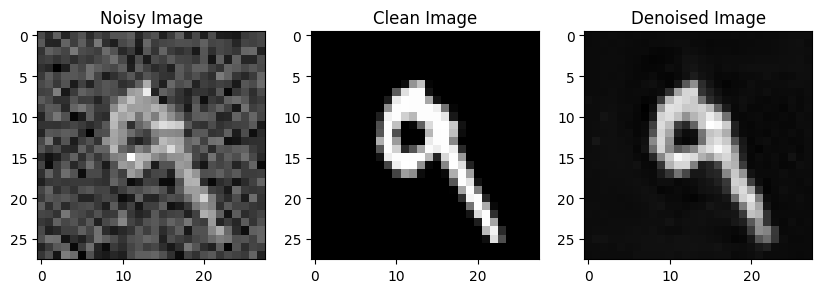

In [226]:
image, target, label = next(iter(test_loader))
noisy_imgs = add_noise(image)
out = model(noisy_imgs).detach().numpy()

import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

idx = 7
ax1.imshow(noisy_imgs[idx].squeeze(), cmap='gray')
ax1.set_title('Noisy Image')
ax2.imshow(image[idx].squeeze(), cmap='gray')
ax2.set_title('Clean Image')
ax3.imshow(out[idx].squeeze(), cmap='gray')
ax3.set_title('Denoised Image')
plt.show()

# Add labels as features

In [5]:
class LabelEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(10, 16),
            nn.ReLU(),
            nn.Linear(16, 32)
        )

    def forward(self, x):
        return self.encoder(x)

In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.pool1 = nn.MaxPool2d(kernel_size=2)


    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.pool1(x1)
        return x1, x2
    

class UpBlock(nn.Module):
    def __init__(self, in_channels, residual_channels, out_channels):
        super().__init__()

        self.upconv1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(in_channels=in_channels + residual_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)


    def forward(self, x1, residual):
        x3 = self.upconv1(x1)
        x3 = torch.cat([x3, residual], dim=1)
        x4 = F.relu(self.bn1(self.conv1(x3)))
        return x4
            

class UNetSmol(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super().__init__()

        # Encoder
        self.down1 = DownBlock(in_channels=input_channels, out_channels=4)
        self.down2 = DownBlock(in_channels=4, out_channels=8)

        # Bottleneck
        self.conv3 = nn.Conv2d(8, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        # Decoder
        self.up1 = UpBlock(in_channels=64, residual_channels=8, out_channels=8)
        self.up2 = UpBlock(in_channels=40, residual_channels=4, out_channels=4)
        self.conv6 = nn.Conv2d(4, output_channels, kernel_size=1)

        self.label_encoder = LabelEncoder()
        # load pretrained
        self.label_encoder.load_state_dict(torch.load('label_encoder.pth'))
        # do not train
        for param in self.label_encoder.parameters():
            param.requires_grad = False


    def forward(self, x, labels=None):
        x1, x2 = self.down1(x)
        x3, x4 = self.down2(x2)

        x5 = F.relu(self.bn3(self.conv3(x4)))

        labels = self.label_encoder(labels)
        # tile labels to shape  (batch_size, 32, 7, 7)
        labels_1 = labels.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, 14, 14)
        x3 = torch.cat([x3, labels_1], dim=1)

        x6 = self.up1(x5, x3)

        labels_2 = labels.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, 28, 28)
        x1 = torch.cat([x1, labels_2], dim=1)

        x7 = self.up2(x6, x1)

        x8 = self.conv6(x7)
        return x8

In [146]:
model = UNetSmol()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [147]:
num_epochs = 5

from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for image, target, labels in tqdm(train_loader):
        noisy_imgs = add_noise(image)
        noisy_imgs, target = noisy_imgs.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(noisy_imgs, labels)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for image, target, labels in test_loader:
            noisy_imgs = add_noise(image)
            noisy_imgs, target = noisy_imgs.to(device), target.to(device)
            outputs = model(noisy_imgs, labels)
            loss = criterion(outputs, target)
            val_loss += loss.item()
    
    print(f'Validation Loss: {val_loss/len(test_loader):.4f}')


100%|██████████| 1875/1875 [03:50<00:00,  8.15it/s]


Epoch [1/5], Loss: 0.1569
Validation Loss: 0.1653


100%|██████████| 1875/1875 [03:06<00:00, 10.03it/s]


Epoch [2/5], Loss: 0.1016
Validation Loss: 0.1556


  4%|▍         | 81/1875 [00:08<03:19,  9.01it/s]


KeyboardInterrupt: 

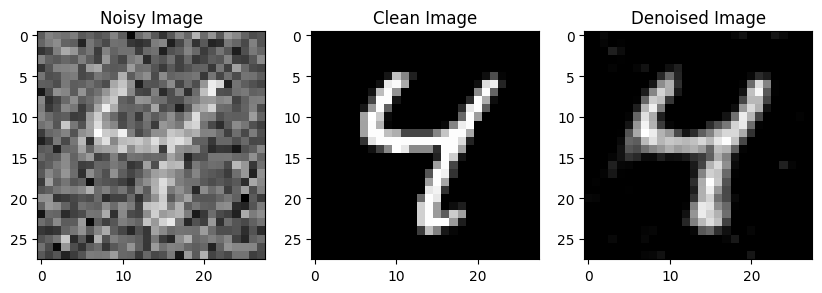

In [179]:
image, target, label = next(iter(test_loader))
noisy_imgs = add_noise(image)
out = model(noisy_imgs, label).detach().numpy()

import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

idx = 6
ax1.imshow(noisy_imgs[idx].squeeze(), cmap='gray')
ax1.set_title('Noisy Image')
ax2.imshow(image[idx].squeeze(), cmap='gray')
ax2.set_title('Clean Image')
ax3.imshow(out[idx].squeeze(), cmap='gray')
ax3.set_title('Denoised Image')
plt.show()

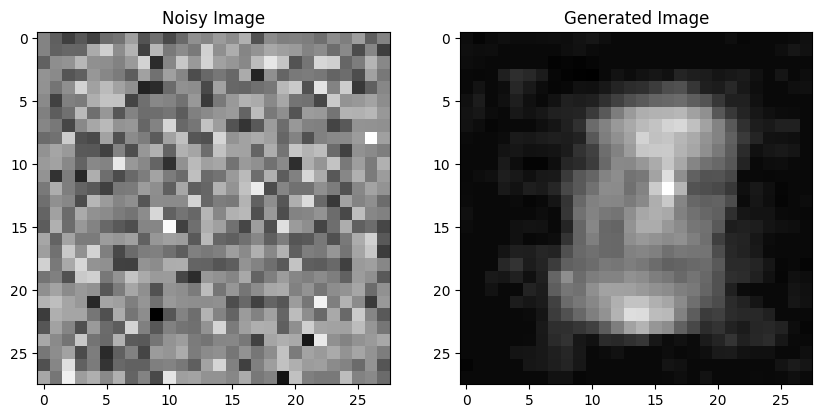

In [189]:
pure_noise = torch.normal(mean=0.0, std=1.0, size=(1, 1, 28, 28))

label = np.zeros(10)
label[0] = 1
label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

out = model(pure_noise, label).detach().numpy()

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

idx = 0
ax1.imshow(pure_noise.squeeze(), cmap='gray')
ax1.set_title('Noisy Image')
ax2.imshow(out.squeeze(), cmap='gray')
ax2.set_title('Generated Image')
plt.show()